                 Model  Accuracy
0        Random Forest  0.744681
1                  SVM  0.702128
2  Logistic Regression  0.702128


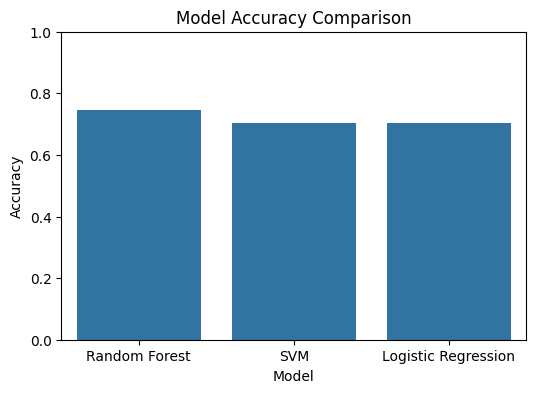


Random Forest Classification Report:

                        precision    recall  f1-score   support

 B12/Folate Deficiency       0.00      0.00      0.00         1
Chronic Disease Anemia       0.75      1.00      0.86         3
      Hemolytic Anemia       0.57      0.80      0.67         5
Iron Deficiency Anemia       0.75      0.75      0.75         4
             No Anemia       0.89      0.80      0.84        10
     Normocytic Anemia       0.83      0.91      0.87        11
     Thalassemia Trait       0.00      0.00      0.00         1
   Unclassified Anemia       0.70      0.58      0.64        12

              accuracy                           0.74        47
             macro avg       0.56      0.61      0.58        47
          weighted avg       0.74      0.74      0.73        47



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Model, Imputer, Scaler, and Encoder saved successfully!


In [1]:
# ============================
# STEP 1: MODEL BUILDING (ONE CELL - NaN FIXED)
# ============================

# 1. Import Libraries
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Dataset
df = pd.read_csv('/content/Data_with_Anemia_TypeN.csv')
df = df.drop(columns=['Unnamed: 10'], errors='ignore')

# 3. Features & Target
X = df.drop(columns=['Anemia_Type', 'Patient ID'])
y = df['Anemia_Type']

# 4. Encode Gender
X['Gender'] = X['Gender'].map({'MALE': 0, 'FEMALE': 1})

# 5. Encode Target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 7. Handle Missing Values (CRITICAL FIX)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 8. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 9. Train Models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=1000)

rf.fit(X_train_imputed, y_train)        # RF uses imputed (no scaling needed)
svm.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)

# 10. Predictions
rf_pred = rf.predict(X_test_imputed)
svm_pred = svm.predict(X_test_scaled)
lr_pred = lr.predict(X_test_scaled)

# 11. Accuracy Comparison
results = {
    "Random Forest": accuracy_score(y_test, rf_pred),
    "SVM": accuracy_score(y_test, svm_pred),
    "Logistic Regression": accuracy_score(y_test, lr_pred)
}

results_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
print(results_df)

# 12. Accuracy Plot
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()

# 13. Best Model Report
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, rf_pred, target_names=label_encoder.classes_))

# 14. Save Everything for Streamlit
joblib.dump(rf, "anemia_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("\n✅ Model, Imputer, Scaler, and Encoder saved successfully!")


In [2]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 11.2 MB/s eta 0:00:00


In [3]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# ===============================
# LOAD TRAINED OBJECTS
# ===============================
model = joblib.load("/content/anemia_model.pkl")
scaler = joblib.load("/content/scaler.pkl")
imputer = joblib.load("/content/imputer.pkl")
encoder = joblib.load("/content/label_encoder.pkl")

# ===============================
# PAGE CONFIG
# ===============================
st.set_page_config(
    page_title="Anemia Classification System",
    layout="centered"
)

# ===============================
# TITLE
# ===============================
st.title("🩸 Anemia Classification System")

# ===============================
# MEDICAL DISCLAIMER
# ===============================
st.warning("""
⚠️ **Medical Disclaimer**

This is an **AI-based tool to classify anemia**.

The prediction is intended **only for screening and academic purposes**.
Final confirmation **must be done by healthcare professionals** using
further clinical investigations such as:

• Iron studies
• Peripheral blood smear examination
• Ferritin / Fe studies
• Hb electrophoresis
• Other relevant laboratory tests

❗ **This tool should NOT be used as a substitute for medical diagnosis.**
""")

st.markdown("---")

# ===============================
# TABS
# ===============================
tab1, tab2 = st.tabs(["📂 Upload CSV", "✍️ Manual Patient Entry"])

# ===============================
# TAB 1: CSV UPLOAD
# ===============================
with tab1:
    st.subheader("Upload Patient CSV File")

    uploaded_file = st.file_uploader(
        "Upload CSV file containing patient data",
        type=["csv"]
    )

    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)

        # Encode Gender
        data['Gender'] = data['Gender'].map({'MALE': 0, 'FEMALE': 1})

        # Drop PatientID if exists
        X = data.drop(columns=['PatientID'], errors='ignore')

        # Handle missing values + scaling
        X_imputed = imputer.transform(X)
        X_scaled = scaler.transform(X_imputed)

        # Prediction
        predictions = model.predict(X_imputed)
        data['Predicted_Anemia_Type'] = encoder.inverse_transform(predictions)

        st.success("✅ Prediction completed successfully")
        st.dataframe(data)

# ===============================
# TAB 2: MANUAL ENTRY
# ===============================
with tab2:
    st.subheader("Enter Patient Details Manually")

    age = st.number_input("Age", min_value=0)
    gender = st.selectbox("Gender", ["MALE", "FEMALE"])
    rbc = st.number_input("RBC (10¹²/L)")
    hgb = st.number_input("HGB (g/dL)")
    hct = st.number_input("HCT (%)")
    mcv = st.number_input("MCV (fL)")
    mch = st.number_input("MCH (pg)")
    mchc = st.number_input("MCHC (g/dL)")
    rdw = st.number_input("RDW-CV (%)")

    if st.button("🔍 Predict Anemia"):
        gender_encoded = 0 if gender == "MALE" else 1

        input_df = pd.DataFrame([[
            age, gender_encoded, rbc, hgb, hct, mcv, mch, mchc, rdw
        ]], columns=[
            'Age', 'Gender', 'RBC', 'HGB', 'HCT',
            'MCV', 'MCH', 'MCHC', 'RDW'
        ])

        # Impute + scale
        input_imputed = imputer.transform(input_df)
        input_scaled = scaler.transform(input_imputed)

        # Predict
        prediction = encoder.inverse_transform(
            model.predict(input_imputed)
        )[0]

        if prediction == "No Anemia":
            st.success("✅ **Patient is NOT Anemic**")
        else:
            st.error(f"⚠️ **Predicted Anemia Type:** {prediction}")


Writing app.py
